In [5]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [2]:
import keras
import pickle
import numpy as np
from numpy.random import randn, randint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense

In [8]:
with open("small_signature_dataset.pkl", "rb") as f:
    train_features, test_features, train_labels, test_labels = pickle.load(f)

In [6]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


In [7]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [8]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [9]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

In [10]:
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [11]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [12]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [15]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20)

>1, 1/468, d1=0.692, d2=0.697 g=0.690
>1, 2/468, d1=0.611, d2=0.701 g=0.685
>1, 3/468, d1=0.553, d2=0.710 g=0.677
>1, 4/468, d1=0.496, d2=0.725 g=0.664
>1, 5/468, d1=0.444, d2=0.748 g=0.645
>1, 6/468, d1=0.393, d2=0.780 g=0.621
>1, 7/468, d1=0.358, d2=0.814 g=0.603
>1, 8/468, d1=0.338, d2=0.848 g=0.601
>1, 9/468, d1=0.340, d2=0.833 g=0.627
>1, 10/468, d1=0.313, d2=0.774 g=0.696
>1, 11/468, d1=0.304, d2=0.682 g=0.794
>1, 12/468, d1=0.348, d2=0.597 g=0.906
>1, 13/468, d1=0.308, d2=0.511 g=1.015
>1, 14/468, d1=0.302, d2=0.467 g=1.071
>1, 15/468, d1=0.385, d2=0.479 g=1.030
>1, 16/468, d1=0.260, d2=0.521 g=0.943
>1, 17/468, d1=0.350, d2=0.575 g=0.840
>1, 18/468, d1=0.267, d2=0.630 g=0.770
>1, 19/468, d1=0.243, d2=0.674 g=0.719
>1, 20/468, d1=0.192, d2=0.747 g=0.658
>1, 21/468, d1=0.176, d2=0.893 g=0.555
>1, 22/468, d1=0.193, d2=1.062 g=0.478
>1, 23/468, d1=0.131, d2=1.172 g=0.446
>1, 24/468, d1=0.120, d2=1.176 g=0.466
>1, 25/468, d1=0.112, d2=1.014 g=0.560
>1, 26/468, d1=0.093, d2=0.796 g=0

>1, 209/468, d1=0.628, d2=0.820 g=0.678
>1, 210/468, d1=0.624, d2=0.849 g=0.668
>1, 211/468, d1=0.603, d2=0.828 g=0.664
>1, 212/468, d1=0.622, d2=0.847 g=0.677
>1, 213/468, d1=0.630, d2=0.818 g=0.675
>1, 214/468, d1=0.656, d2=0.788 g=0.691
>1, 215/468, d1=0.648, d2=0.772 g=0.710
>1, 216/468, d1=0.662, d2=0.731 g=0.753
>1, 217/468, d1=0.598, d2=0.693 g=0.796
>1, 218/468, d1=0.631, d2=0.664 g=0.843
>1, 219/468, d1=0.602, d2=0.641 g=0.881
>1, 220/468, d1=0.587, d2=0.612 g=0.885
>1, 221/468, d1=0.563, d2=0.592 g=0.919
>1, 222/468, d1=0.566, d2=0.594 g=0.922
>1, 223/468, d1=0.551, d2=0.589 g=0.947
>1, 224/468, d1=0.567, d2=0.586 g=0.920
>1, 225/468, d1=0.538, d2=0.580 g=0.930
>1, 226/468, d1=0.511, d2=0.589 g=0.896
>1, 227/468, d1=0.543, d2=0.597 g=0.936
>1, 228/468, d1=0.502, d2=0.563 g=0.915
>1, 229/468, d1=0.460, d2=0.592 g=0.901
>1, 230/468, d1=0.524, d2=0.638 g=0.887
>1, 231/468, d1=0.523, d2=0.690 g=0.819
>1, 232/468, d1=0.484, d2=0.769 g=0.722
>1, 233/468, d1=0.566, d2=0.908 g=0.606


>1, 414/468, d1=0.674, d2=0.683 g=0.754
>1, 415/468, d1=0.711, d2=0.653 g=0.755
>1, 416/468, d1=0.698, d2=0.658 g=0.752
>1, 417/468, d1=0.702, d2=0.657 g=0.771
>1, 418/468, d1=0.690, d2=0.644 g=0.776
>1, 419/468, d1=0.680, d2=0.647 g=0.776
>1, 420/468, d1=0.664, d2=0.638 g=0.802
>1, 421/468, d1=0.650, d2=0.624 g=0.811
>1, 422/468, d1=0.666, d2=0.629 g=0.801
>1, 423/468, d1=0.663, d2=0.608 g=0.800
>1, 424/468, d1=0.693, d2=0.656 g=0.806
>1, 425/468, d1=0.637, d2=0.657 g=0.804
>1, 426/468, d1=0.658, d2=0.633 g=0.784
>1, 427/468, d1=0.663, d2=0.642 g=0.802
>1, 428/468, d1=0.640, d2=0.651 g=0.781
>1, 429/468, d1=0.644, d2=0.668 g=0.767
>1, 430/468, d1=0.650, d2=0.664 g=0.761
>1, 431/468, d1=0.635, d2=0.668 g=0.761
>1, 432/468, d1=0.650, d2=0.648 g=0.755
>1, 433/468, d1=0.653, d2=0.659 g=0.785
>1, 434/468, d1=0.646, d2=0.678 g=0.779
>1, 435/468, d1=0.641, d2=0.632 g=0.797
>1, 436/468, d1=0.611, d2=0.667 g=0.794
>1, 437/468, d1=0.640, d2=0.626 g=0.823
>1, 438/468, d1=0.652, d2=0.649 g=0.796


>2, 154/468, d1=0.609, d2=0.610 g=0.838
>2, 155/468, d1=0.631, d2=0.616 g=0.813
>2, 156/468, d1=0.604, d2=0.635 g=0.806
>2, 157/468, d1=0.625, d2=0.626 g=0.771
>2, 158/468, d1=0.681, d2=0.655 g=0.769
>2, 159/468, d1=0.629, d2=0.689 g=0.747
>2, 160/468, d1=0.600, d2=0.685 g=0.736
>2, 161/468, d1=0.606, d2=0.731 g=0.779
>2, 162/468, d1=0.617, d2=0.676 g=0.750
>2, 163/468, d1=0.599, d2=0.662 g=0.742
>2, 164/468, d1=0.624, d2=0.668 g=0.810
>2, 165/468, d1=0.617, d2=0.657 g=0.813
>2, 166/468, d1=0.654, d2=0.625 g=0.818
>2, 167/468, d1=0.661, d2=0.632 g=0.858
>2, 168/468, d1=0.672, d2=0.671 g=0.806
>2, 169/468, d1=0.661, d2=0.665 g=0.781
>2, 170/468, d1=0.655, d2=0.702 g=0.754
>2, 171/468, d1=0.644, d2=0.714 g=0.732
>2, 172/468, d1=0.613, d2=0.756 g=0.708
>2, 173/468, d1=0.599, d2=0.745 g=0.654
>2, 174/468, d1=0.607, d2=0.790 g=0.661
>2, 175/468, d1=0.614, d2=0.790 g=0.654
>2, 176/468, d1=0.629, d2=0.779 g=0.684
>2, 177/468, d1=0.622, d2=0.744 g=0.690
>2, 178/468, d1=0.633, d2=0.757 g=0.706


>2, 359/468, d1=0.746, d2=0.690 g=0.785
>2, 360/468, d1=0.705, d2=0.690 g=0.754
>2, 361/468, d1=0.736, d2=0.669 g=0.794
>2, 362/468, d1=0.705, d2=0.663 g=0.795
>2, 363/468, d1=0.644, d2=0.692 g=0.810
>2, 364/468, d1=0.725, d2=0.702 g=0.770
>2, 365/468, d1=0.690, d2=0.660 g=0.802
>2, 366/468, d1=0.684, d2=0.670 g=0.788
>2, 367/468, d1=0.692, d2=0.646 g=0.790
>2, 368/468, d1=0.700, d2=0.660 g=0.822
>2, 369/468, d1=0.695, d2=0.686 g=0.777
>2, 370/468, d1=0.757, d2=0.648 g=0.802
>2, 371/468, d1=0.708, d2=0.659 g=0.772
>2, 372/468, d1=0.752, d2=0.685 g=0.782
>2, 373/468, d1=0.730, d2=0.680 g=0.767
>2, 374/468, d1=0.684, d2=0.688 g=0.766
>2, 375/468, d1=0.715, d2=0.706 g=0.767
>2, 376/468, d1=0.699, d2=0.704 g=0.791
>2, 377/468, d1=0.716, d2=0.653 g=0.784
>2, 378/468, d1=0.709, d2=0.677 g=0.784
>2, 379/468, d1=0.720, d2=0.676 g=0.753
>2, 380/468, d1=0.703, d2=0.684 g=0.787
>2, 381/468, d1=0.688, d2=0.689 g=0.765
>2, 382/468, d1=0.707, d2=0.693 g=0.766
>2, 383/468, d1=0.736, d2=0.691 g=0.752


>3, 99/468, d1=0.667, d2=0.650 g=0.787
>3, 100/468, d1=0.654, d2=0.648 g=0.791
>3, 101/468, d1=0.652, d2=0.648 g=0.782
>3, 102/468, d1=0.616, d2=0.669 g=0.783
>3, 103/468, d1=0.644, d2=0.666 g=0.775
>3, 104/468, d1=0.639, d2=0.697 g=0.758
>3, 105/468, d1=0.631, d2=0.687 g=0.746
>3, 106/468, d1=0.659, d2=0.668 g=0.778
>3, 107/468, d1=0.654, d2=0.667 g=0.786
>3, 108/468, d1=0.640, d2=0.662 g=0.783
>3, 109/468, d1=0.647, d2=0.654 g=0.789
>3, 110/468, d1=0.670, d2=0.627 g=0.755
>3, 111/468, d1=0.679, d2=0.657 g=0.801
>3, 112/468, d1=0.656, d2=0.660 g=0.757
>3, 113/468, d1=0.632, d2=0.681 g=0.751
>3, 114/468, d1=0.642, d2=0.679 g=0.758
>3, 115/468, d1=0.620, d2=0.691 g=0.765
>3, 116/468, d1=0.642, d2=0.691 g=0.762
>3, 117/468, d1=0.646, d2=0.672 g=0.788
>3, 118/468, d1=0.661, d2=0.642 g=0.807
>3, 119/468, d1=0.678, d2=0.625 g=0.853
>3, 120/468, d1=0.660, d2=0.628 g=0.834
>3, 121/468, d1=0.684, d2=0.607 g=0.856
>3, 122/468, d1=0.688, d2=0.631 g=0.849
>3, 123/468, d1=0.693, d2=0.620 g=0.804
>

>3, 304/468, d1=0.661, d2=0.639 g=0.811
>3, 305/468, d1=0.642, d2=0.639 g=0.805
>3, 306/468, d1=0.648, d2=0.664 g=0.769
>3, 307/468, d1=0.655, d2=0.652 g=0.751
>3, 308/468, d1=0.712, d2=0.657 g=0.743
>3, 309/468, d1=0.680, d2=0.671 g=0.752
>3, 310/468, d1=0.665, d2=0.685 g=0.742
>3, 311/468, d1=0.701, d2=0.689 g=0.751
>3, 312/468, d1=0.665, d2=0.679 g=0.753
>3, 313/468, d1=0.663, d2=0.674 g=0.763
>3, 314/468, d1=0.655, d2=0.670 g=0.750
>3, 315/468, d1=0.667, d2=0.662 g=0.751
>3, 316/468, d1=0.676, d2=0.681 g=0.762
>3, 317/468, d1=0.656, d2=0.669 g=0.762
>3, 318/468, d1=0.636, d2=0.663 g=0.754
>3, 319/468, d1=0.665, d2=0.697 g=0.772
>3, 320/468, d1=0.669, d2=0.685 g=0.794
>3, 321/468, d1=0.648, d2=0.639 g=0.795
>3, 322/468, d1=0.683, d2=0.656 g=0.811
>3, 323/468, d1=0.681, d2=0.621 g=0.814
>3, 324/468, d1=0.686, d2=0.613 g=0.818
>3, 325/468, d1=0.684, d2=0.668 g=0.790
>3, 326/468, d1=0.677, d2=0.666 g=0.770
>3, 327/468, d1=0.664, d2=0.672 g=0.765
>3, 328/468, d1=0.664, d2=0.673 g=0.754


>4, 43/468, d1=0.666, d2=0.663 g=0.771
>4, 44/468, d1=0.679, d2=0.671 g=0.772
>4, 45/468, d1=0.652, d2=0.670 g=0.755
>4, 46/468, d1=0.662, d2=0.657 g=0.767
>4, 47/468, d1=0.678, d2=0.675 g=0.776
>4, 48/468, d1=0.690, d2=0.642 g=0.797
>4, 49/468, d1=0.667, d2=0.642 g=0.829
>4, 50/468, d1=0.682, d2=0.648 g=0.810
>4, 51/468, d1=0.695, d2=0.611 g=0.825
>4, 52/468, d1=0.691, d2=0.625 g=0.816
>4, 53/468, d1=0.675, d2=0.613 g=0.802
>4, 54/468, d1=0.684, d2=0.633 g=0.790
>4, 55/468, d1=0.683, d2=0.649 g=0.780
>4, 56/468, d1=0.654, d2=0.651 g=0.781
>4, 57/468, d1=0.659, d2=0.665 g=0.777
>4, 58/468, d1=0.651, d2=0.629 g=0.777
>4, 59/468, d1=0.645, d2=0.631 g=0.778
>4, 60/468, d1=0.655, d2=0.633 g=0.796
>4, 61/468, d1=0.667, d2=0.639 g=0.802
>4, 62/468, d1=0.654, d2=0.643 g=0.781
>4, 63/468, d1=0.641, d2=0.668 g=0.775
>4, 64/468, d1=0.644, d2=0.659 g=0.780
>4, 65/468, d1=0.627, d2=0.664 g=0.752
>4, 66/468, d1=0.634, d2=0.660 g=0.758
>4, 67/468, d1=0.631, d2=0.676 g=0.760
>4, 68/468, d1=0.660, d2=

>4, 250/468, d1=0.613, d2=0.664 g=0.791
>4, 251/468, d1=0.655, d2=0.685 g=0.779
>4, 252/468, d1=0.625, d2=0.666 g=0.783
>4, 253/468, d1=0.593, d2=0.641 g=0.763
>4, 254/468, d1=0.659, d2=0.651 g=0.772
>4, 255/468, d1=0.639, d2=0.663 g=0.779
>4, 256/468, d1=0.651, d2=0.673 g=0.803
>4, 257/468, d1=0.647, d2=0.643 g=0.797
>4, 258/468, d1=0.670, d2=0.644 g=0.804
>4, 259/468, d1=0.638, d2=0.641 g=0.803
>4, 260/468, d1=0.682, d2=0.620 g=0.822
>4, 261/468, d1=0.661, d2=0.634 g=0.827
>4, 262/468, d1=0.711, d2=0.610 g=0.814
>4, 263/468, d1=0.677, d2=0.623 g=0.812
>4, 264/468, d1=0.698, d2=0.610 g=0.804
>4, 265/468, d1=0.684, d2=0.622 g=0.790
>4, 266/468, d1=0.641, d2=0.635 g=0.790
>4, 267/468, d1=0.686, d2=0.656 g=0.775
>4, 268/468, d1=0.671, d2=0.631 g=0.772
>4, 269/468, d1=0.644, d2=0.641 g=0.779
>4, 270/468, d1=0.640, d2=0.660 g=0.778
>4, 271/468, d1=0.634, d2=0.657 g=0.771
>4, 272/468, d1=0.612, d2=0.632 g=0.783
>4, 273/468, d1=0.642, d2=0.647 g=0.750
>4, 274/468, d1=0.635, d2=0.676 g=0.769


>4, 455/468, d1=0.715, d2=0.627 g=0.860
>4, 456/468, d1=0.716, d2=0.611 g=0.821
>4, 457/468, d1=0.682, d2=0.674 g=0.807
>4, 458/468, d1=0.664, d2=0.649 g=0.793
>4, 459/468, d1=0.659, d2=0.636 g=0.806
>4, 460/468, d1=0.653, d2=0.668 g=0.785
>4, 461/468, d1=0.646, d2=0.669 g=0.749
>4, 462/468, d1=0.646, d2=0.657 g=0.765
>4, 463/468, d1=0.678, d2=0.683 g=0.746
>4, 464/468, d1=0.640, d2=0.705 g=0.745
>4, 465/468, d1=0.633, d2=0.635 g=0.779
>4, 466/468, d1=0.647, d2=0.669 g=0.781
>4, 467/468, d1=0.618, d2=0.681 g=0.795
>4, 468/468, d1=0.690, d2=0.668 g=0.787
>5, 1/468, d1=0.611, d2=0.636 g=0.791
>5, 2/468, d1=0.660, d2=0.659 g=0.768
>5, 3/468, d1=0.664, d2=0.664 g=0.769
>5, 4/468, d1=0.646, d2=0.664 g=0.783
>5, 5/468, d1=0.640, d2=0.678 g=0.794
>5, 6/468, d1=0.684, d2=0.650 g=0.800
>5, 7/468, d1=0.726, d2=0.641 g=0.812
>5, 8/468, d1=0.667, d2=0.619 g=0.808
>5, 9/468, d1=0.702, d2=0.617 g=0.839
>5, 10/468, d1=0.674, d2=0.655 g=0.800
>5, 11/468, d1=0.685, d2=0.647 g=0.757
>5, 12/468, d1=0.674

>5, 195/468, d1=0.706, d2=0.642 g=0.796
>5, 196/468, d1=0.705, d2=0.671 g=0.792
>5, 197/468, d1=0.648, d2=0.668 g=0.778
>5, 198/468, d1=0.677, d2=0.644 g=0.786
>5, 199/468, d1=0.638, d2=0.648 g=0.795
>5, 200/468, d1=0.668, d2=0.665 g=0.780
>5, 201/468, d1=0.674, d2=0.655 g=0.796
>5, 202/468, d1=0.668, d2=0.638 g=0.778
>5, 203/468, d1=0.639, d2=0.656 g=0.772
>5, 204/468, d1=0.654, d2=0.676 g=0.746
>5, 205/468, d1=0.607, d2=0.728 g=0.728
>5, 206/468, d1=0.645, d2=0.740 g=0.723
>5, 207/468, d1=0.675, d2=0.722 g=0.745
>5, 208/468, d1=0.666, d2=0.686 g=0.783
>5, 209/468, d1=0.666, d2=0.659 g=0.811
>5, 210/468, d1=0.686, d2=0.604 g=0.866
>5, 211/468, d1=0.693, d2=0.591 g=0.844
>5, 212/468, d1=0.674, d2=0.598 g=0.860
>5, 213/468, d1=0.708, d2=0.617 g=0.841
>5, 214/468, d1=0.724, d2=0.687 g=0.798
>5, 215/468, d1=0.689, d2=0.697 g=0.760
>5, 216/468, d1=0.720, d2=0.707 g=0.738
>5, 217/468, d1=0.709, d2=0.659 g=0.755
>5, 218/468, d1=0.650, d2=0.663 g=0.792
>5, 219/468, d1=0.654, d2=0.627 g=0.825


>5, 400/468, d1=0.646, d2=0.675 g=0.739
>5, 401/468, d1=0.679, d2=0.670 g=0.770
>5, 402/468, d1=0.676, d2=0.676 g=0.776
>5, 403/468, d1=0.638, d2=0.657 g=0.803
>5, 404/468, d1=0.665, d2=0.671 g=0.798
>5, 405/468, d1=0.693, d2=0.650 g=0.763
>5, 406/468, d1=0.655, d2=0.678 g=0.758
>5, 407/468, d1=0.630, d2=0.656 g=0.765
>5, 408/468, d1=0.640, d2=0.656 g=0.777
>5, 409/468, d1=0.626, d2=0.672 g=0.790
>5, 410/468, d1=0.657, d2=0.693 g=0.773
>5, 411/468, d1=0.675, d2=0.674 g=0.798
>5, 412/468, d1=0.641, d2=0.667 g=0.783
>5, 413/468, d1=0.641, d2=0.653 g=0.784
>5, 414/468, d1=0.668, d2=0.643 g=0.753
>5, 415/468, d1=0.668, d2=0.655 g=0.784
>5, 416/468, d1=0.639, d2=0.643 g=0.785
>5, 417/468, d1=0.640, d2=0.676 g=0.761
>5, 418/468, d1=0.649, d2=0.655 g=0.777
>5, 419/468, d1=0.664, d2=0.649 g=0.777
>5, 420/468, d1=0.646, d2=0.666 g=0.769
>5, 421/468, d1=0.659, d2=0.647 g=0.790
>5, 422/468, d1=0.666, d2=0.654 g=0.779
>5, 423/468, d1=0.654, d2=0.658 g=0.770
>5, 424/468, d1=0.670, d2=0.638 g=0.780


>6, 140/468, d1=0.689, d2=0.641 g=0.818
>6, 141/468, d1=0.650, d2=0.633 g=0.792
>6, 142/468, d1=0.675, d2=0.641 g=0.796
>6, 143/468, d1=0.689, d2=0.683 g=0.783
>6, 144/468, d1=0.668, d2=0.650 g=0.781
>6, 145/468, d1=0.676, d2=0.655 g=0.813
>6, 146/468, d1=0.691, d2=0.632 g=0.812
>6, 147/468, d1=0.654, d2=0.656 g=0.809
>6, 148/468, d1=0.672, d2=0.636 g=0.820
>6, 149/468, d1=0.637, d2=0.658 g=0.792
>6, 150/468, d1=0.647, d2=0.676 g=0.788
>6, 151/468, d1=0.673, d2=0.654 g=0.795
>6, 152/468, d1=0.655, d2=0.671 g=0.779
>6, 153/468, d1=0.677, d2=0.652 g=0.781
>6, 154/468, d1=0.660, d2=0.679 g=0.769
>6, 155/468, d1=0.668, d2=0.665 g=0.799
>6, 156/468, d1=0.701, d2=0.648 g=0.793
>6, 157/468, d1=0.674, d2=0.637 g=0.801
>6, 158/468, d1=0.686, d2=0.617 g=0.841
>6, 159/468, d1=0.680, d2=0.614 g=0.836
>6, 160/468, d1=0.694, d2=0.635 g=0.828
>6, 161/468, d1=0.699, d2=0.634 g=0.822
>6, 162/468, d1=0.704, d2=0.657 g=0.788
>6, 163/468, d1=0.663, d2=0.630 g=0.811
>6, 164/468, d1=0.665, d2=0.664 g=0.793


>6, 345/468, d1=0.645, d2=0.675 g=0.782
>6, 346/468, d1=0.668, d2=0.633 g=0.804
>6, 347/468, d1=0.674, d2=0.660 g=0.803
>6, 348/468, d1=0.650, d2=0.653 g=0.795
>6, 349/468, d1=0.672, d2=0.625 g=0.786
>6, 350/468, d1=0.651, d2=0.666 g=0.781
>6, 351/468, d1=0.690, d2=0.677 g=0.777
>6, 352/468, d1=0.671, d2=0.648 g=0.803
>6, 353/468, d1=0.671, d2=0.653 g=0.805
>6, 354/468, d1=0.669, d2=0.656 g=0.804
>6, 355/468, d1=0.645, d2=0.599 g=0.813
>6, 356/468, d1=0.641, d2=0.638 g=0.811
>6, 357/468, d1=0.683, d2=0.630 g=0.831
>6, 358/468, d1=0.662, d2=0.662 g=0.798
>6, 359/468, d1=0.661, d2=0.612 g=0.774
>6, 360/468, d1=0.665, d2=0.642 g=0.783
>6, 361/468, d1=0.684, d2=0.691 g=0.796
>6, 362/468, d1=0.660, d2=0.665 g=0.785
>6, 363/468, d1=0.658, d2=0.630 g=0.799
>6, 364/468, d1=0.685, d2=0.637 g=0.803
>6, 365/468, d1=0.693, d2=0.663 g=0.774
>6, 366/468, d1=0.652, d2=0.646 g=0.763
>6, 367/468, d1=0.670, d2=0.667 g=0.784
>6, 368/468, d1=0.651, d2=0.676 g=0.775
>6, 369/468, d1=0.682, d2=0.653 g=0.788


>7, 85/468, d1=0.702, d2=0.692 g=0.766
>7, 86/468, d1=0.650, d2=0.685 g=0.761
>7, 87/468, d1=0.644, d2=0.646 g=0.811
>7, 88/468, d1=0.692, d2=0.643 g=0.848
>7, 89/468, d1=0.681, d2=0.621 g=0.806
>7, 90/468, d1=0.667, d2=0.608 g=0.829
>7, 91/468, d1=0.658, d2=0.629 g=0.824
>7, 92/468, d1=0.688, d2=0.632 g=0.798
>7, 93/468, d1=0.692, d2=0.621 g=0.778
>7, 94/468, d1=0.670, d2=0.678 g=0.773
>7, 95/468, d1=0.672, d2=0.676 g=0.764
>7, 96/468, d1=0.643, d2=0.685 g=0.769
>7, 97/468, d1=0.671, d2=0.636 g=0.778
>7, 98/468, d1=0.703, d2=0.639 g=0.796
>7, 99/468, d1=0.665, d2=0.678 g=0.798
>7, 100/468, d1=0.643, d2=0.638 g=0.778
>7, 101/468, d1=0.663, d2=0.673 g=0.759
>7, 102/468, d1=0.665, d2=0.683 g=0.732
>7, 103/468, d1=0.600, d2=0.701 g=0.757
>7, 104/468, d1=0.683, d2=0.671 g=0.767
>7, 105/468, d1=0.671, d2=0.671 g=0.752
>7, 106/468, d1=0.621, d2=0.642 g=0.765
>7, 107/468, d1=0.681, d2=0.671 g=0.771
>7, 108/468, d1=0.636, d2=0.659 g=0.796
>7, 109/468, d1=0.658, d2=0.644 g=0.792
>7, 110/468, d1

>7, 291/468, d1=0.656, d2=0.685 g=0.763
>7, 292/468, d1=0.663, d2=0.682 g=0.772
>7, 293/468, d1=0.631, d2=0.680 g=0.758
>7, 294/468, d1=0.678, d2=0.666 g=0.758
>7, 295/468, d1=0.644, d2=0.671 g=0.775
>7, 296/468, d1=0.673, d2=0.642 g=0.783
>7, 297/468, d1=0.661, d2=0.658 g=0.758
>7, 298/468, d1=0.705, d2=0.675 g=0.765
>7, 299/468, d1=0.680, d2=0.665 g=0.751
>7, 300/468, d1=0.630, d2=0.660 g=0.743
>7, 301/468, d1=0.676, d2=0.658 g=0.764
>7, 302/468, d1=0.634, d2=0.676 g=0.776
>7, 303/468, d1=0.659, d2=0.652 g=0.791
>7, 304/468, d1=0.667, d2=0.699 g=0.778
>7, 305/468, d1=0.672, d2=0.663 g=0.785
>7, 306/468, d1=0.653, d2=0.644 g=0.793
>7, 307/468, d1=0.678, d2=0.680 g=0.777
>7, 308/468, d1=0.671, d2=0.644 g=0.798
>7, 309/468, d1=0.674, d2=0.664 g=0.798
>7, 310/468, d1=0.672, d2=0.641 g=0.799
>7, 311/468, d1=0.704, d2=0.647 g=0.811
>7, 312/468, d1=0.682, d2=0.634 g=0.800
>7, 313/468, d1=0.685, d2=0.663 g=0.791
>7, 314/468, d1=0.667, d2=0.648 g=0.785
>7, 315/468, d1=0.686, d2=0.650 g=0.766


>8, 29/468, d1=0.666, d2=0.680 g=0.782
>8, 30/468, d1=0.672, d2=0.699 g=0.744
>8, 31/468, d1=0.679, d2=0.686 g=0.761
>8, 32/468, d1=0.647, d2=0.707 g=0.780
>8, 33/468, d1=0.690, d2=0.663 g=0.809
>8, 34/468, d1=0.700, d2=0.620 g=0.796
>8, 35/468, d1=0.679, d2=0.636 g=0.833
>8, 36/468, d1=0.675, d2=0.624 g=0.827
>8, 37/468, d1=0.672, d2=0.640 g=0.776
>8, 38/468, d1=0.665, d2=0.636 g=0.798
>8, 39/468, d1=0.655, d2=0.649 g=0.782
>8, 40/468, d1=0.675, d2=0.654 g=0.790
>8, 41/468, d1=0.653, d2=0.647 g=0.771
>8, 42/468, d1=0.652, d2=0.700 g=0.742
>8, 43/468, d1=0.677, d2=0.673 g=0.769
>8, 44/468, d1=0.649, d2=0.675 g=0.760
>8, 45/468, d1=0.669, d2=0.677 g=0.769
>8, 46/468, d1=0.645, d2=0.671 g=0.740
>8, 47/468, d1=0.694, d2=0.637 g=0.787
>8, 48/468, d1=0.647, d2=0.683 g=0.766
>8, 49/468, d1=0.648, d2=0.650 g=0.778
>8, 50/468, d1=0.679, d2=0.650 g=0.778
>8, 51/468, d1=0.654, d2=0.643 g=0.786
>8, 52/468, d1=0.664, d2=0.637 g=0.773
>8, 53/468, d1=0.670, d2=0.642 g=0.767
>8, 54/468, d1=0.684, d2=

>8, 236/468, d1=0.637, d2=0.635 g=0.799
>8, 237/468, d1=0.641, d2=0.673 g=0.807
>8, 238/468, d1=0.652, d2=0.661 g=0.759
>8, 239/468, d1=0.638, d2=0.685 g=0.768
>8, 240/468, d1=0.649, d2=0.685 g=0.778
>8, 241/468, d1=0.694, d2=0.664 g=0.800
>8, 242/468, d1=0.697, d2=0.631 g=0.856
>8, 243/468, d1=0.685, d2=0.622 g=0.840
>8, 244/468, d1=0.714, d2=0.650 g=0.842
>8, 245/468, d1=0.693, d2=0.648 g=0.803
>8, 246/468, d1=0.669, d2=0.633 g=0.795
>8, 247/468, d1=0.702, d2=0.672 g=0.762
>8, 248/468, d1=0.663, d2=0.673 g=0.794
>8, 249/468, d1=0.668, d2=0.677 g=0.781
>8, 250/468, d1=0.640, d2=0.676 g=0.792
>8, 251/468, d1=0.647, d2=0.661 g=0.790
>8, 252/468, d1=0.678, d2=0.671 g=0.777
>8, 253/468, d1=0.654, d2=0.698 g=0.772
>8, 254/468, d1=0.640, d2=0.670 g=0.769
>8, 255/468, d1=0.671, d2=0.660 g=0.784
>8, 256/468, d1=0.658, d2=0.641 g=0.784
>8, 257/468, d1=0.650, d2=0.626 g=0.789
>8, 258/468, d1=0.664, d2=0.636 g=0.789
>8, 259/468, d1=0.705, d2=0.668 g=0.770
>8, 260/468, d1=0.668, d2=0.665 g=0.761


>8, 441/468, d1=0.652, d2=0.609 g=0.850
>8, 442/468, d1=0.639, d2=0.624 g=0.801
>8, 443/468, d1=0.658, d2=0.708 g=0.760
>8, 444/468, d1=0.643, d2=0.703 g=0.760
>8, 445/468, d1=0.660, d2=0.669 g=0.746
>8, 446/468, d1=0.627, d2=0.682 g=0.784
>8, 447/468, d1=0.676, d2=0.646 g=0.805
>8, 448/468, d1=0.672, d2=0.598 g=0.866
>8, 449/468, d1=0.694, d2=0.630 g=0.830
>8, 450/468, d1=0.682, d2=0.622 g=0.798
>8, 451/468, d1=0.716, d2=0.678 g=0.740
>8, 452/468, d1=0.685, d2=0.712 g=0.742
>8, 453/468, d1=0.673, d2=0.709 g=0.747
>8, 454/468, d1=0.647, d2=0.685 g=0.765
>8, 455/468, d1=0.627, d2=0.670 g=0.796
>8, 456/468, d1=0.663, d2=0.636 g=0.782
>8, 457/468, d1=0.669, d2=0.683 g=0.776
>8, 458/468, d1=0.618, d2=0.679 g=0.761
>8, 459/468, d1=0.654, d2=0.678 g=0.753
>8, 460/468, d1=0.661, d2=0.683 g=0.788
>8, 461/468, d1=0.648, d2=0.632 g=0.800
>8, 462/468, d1=0.643, d2=0.640 g=0.803
>8, 463/468, d1=0.677, d2=0.648 g=0.792
>8, 464/468, d1=0.674, d2=0.628 g=0.798
>8, 465/468, d1=0.684, d2=0.661 g=0.759


>9, 181/468, d1=0.693, d2=0.665 g=0.816
>9, 182/468, d1=0.670, d2=0.642 g=0.834
>9, 183/468, d1=0.667, d2=0.606 g=0.883
>9, 184/468, d1=0.682, d2=0.595 g=0.817
>9, 185/468, d1=0.675, d2=0.662 g=0.787
>9, 186/468, d1=0.673, d2=0.659 g=0.765
>9, 187/468, d1=0.691, d2=0.710 g=0.758
>9, 188/468, d1=0.663, d2=0.686 g=0.788
>9, 189/468, d1=0.698, d2=0.638 g=0.822
>9, 190/468, d1=0.635, d2=0.622 g=0.824
>9, 191/468, d1=0.693, d2=0.634 g=0.804
>9, 192/468, d1=0.677, d2=0.705 g=0.748
>9, 193/468, d1=0.669, d2=0.718 g=0.748
>9, 194/468, d1=0.665, d2=0.683 g=0.745
>9, 195/468, d1=0.674, d2=0.632 g=0.821
>9, 196/468, d1=0.713, d2=0.626 g=0.842
>9, 197/468, d1=0.688, d2=0.640 g=0.885
>9, 198/468, d1=0.673, d2=0.606 g=0.849
>9, 199/468, d1=0.664, d2=0.652 g=0.774
>9, 200/468, d1=0.640, d2=0.706 g=0.770
>9, 201/468, d1=0.658, d2=0.653 g=0.754
>9, 202/468, d1=0.668, d2=0.677 g=0.770
>9, 203/468, d1=0.644, d2=0.646 g=0.792
>9, 204/468, d1=0.694, d2=0.663 g=0.785
>9, 205/468, d1=0.617, d2=0.622 g=0.796


>9, 386/468, d1=0.644, d2=0.667 g=0.757
>9, 387/468, d1=0.656, d2=0.678 g=0.777
>9, 388/468, d1=0.656, d2=0.666 g=0.794
>9, 389/468, d1=0.692, d2=0.638 g=0.782
>9, 390/468, d1=0.644, d2=0.669 g=0.747
>9, 391/468, d1=0.673, d2=0.663 g=0.764
>9, 392/468, d1=0.681, d2=0.651 g=0.761
>9, 393/468, d1=0.687, d2=0.689 g=0.783
>9, 394/468, d1=0.695, d2=0.692 g=0.782
>9, 395/468, d1=0.667, d2=0.673 g=0.772
>9, 396/468, d1=0.657, d2=0.681 g=0.747
>9, 397/468, d1=0.684, d2=0.683 g=0.754
>9, 398/468, d1=0.695, d2=0.674 g=0.795
>9, 399/468, d1=0.671, d2=0.674 g=0.779
>9, 400/468, d1=0.689, d2=0.635 g=0.790
>9, 401/468, d1=0.679, d2=0.632 g=0.792
>9, 402/468, d1=0.705, d2=0.663 g=0.780
>9, 403/468, d1=0.687, d2=0.687 g=0.769
>9, 404/468, d1=0.665, d2=0.661 g=0.749
>9, 405/468, d1=0.686, d2=0.654 g=0.790
>9, 406/468, d1=0.656, d2=0.661 g=0.850
>9, 407/468, d1=0.673, d2=0.627 g=0.817
>9, 408/468, d1=0.680, d2=0.674 g=0.740
>9, 409/468, d1=0.689, d2=0.673 g=0.768
>9, 410/468, d1=0.684, d2=0.676 g=0.760


>10, 123/468, d1=0.715, d2=0.614 g=0.780
>10, 124/468, d1=0.623, d2=0.673 g=0.796
>10, 125/468, d1=0.676, d2=0.666 g=0.788
>10, 126/468, d1=0.658, d2=0.682 g=0.764
>10, 127/468, d1=0.691, d2=0.671 g=0.776
>10, 128/468, d1=0.655, d2=0.673 g=0.762
>10, 129/468, d1=0.667, d2=0.682 g=0.767
>10, 130/468, d1=0.678, d2=0.670 g=0.762
>10, 131/468, d1=0.657, d2=0.679 g=0.753
>10, 132/468, d1=0.665, d2=0.681 g=0.744
>10, 133/468, d1=0.686, d2=0.671 g=0.753
>10, 134/468, d1=0.656, d2=0.681 g=0.810
>10, 135/468, d1=0.672, d2=0.627 g=0.786
>10, 136/468, d1=0.703, d2=0.677 g=0.791
>10, 137/468, d1=0.674, d2=0.686 g=0.777
>10, 138/468, d1=0.649, d2=0.665 g=0.792
>10, 139/468, d1=0.680, d2=0.688 g=0.774
>10, 140/468, d1=0.681, d2=0.686 g=0.759
>10, 141/468, d1=0.677, d2=0.684 g=0.772
>10, 142/468, d1=0.649, d2=0.717 g=0.775
>10, 143/468, d1=0.658, d2=0.698 g=0.763
>10, 144/468, d1=0.658, d2=0.692 g=0.777
>10, 145/468, d1=0.680, d2=0.683 g=0.776
>10, 146/468, d1=0.662, d2=0.688 g=0.742
>10, 147/468, d1

>10, 323/468, d1=0.688, d2=0.694 g=0.783
>10, 324/468, d1=0.676, d2=0.683 g=0.782
>10, 325/468, d1=0.693, d2=0.628 g=0.784
>10, 326/468, d1=0.693, d2=0.657 g=0.788
>10, 327/468, d1=0.693, d2=0.672 g=0.771
>10, 328/468, d1=0.662, d2=0.690 g=0.752
>10, 329/468, d1=0.692, d2=0.673 g=0.785
>10, 330/468, d1=0.663, d2=0.669 g=0.828
>10, 331/468, d1=0.671, d2=0.650 g=0.815
>10, 332/468, d1=0.686, d2=0.666 g=0.765
>10, 333/468, d1=0.678, d2=0.665 g=0.775
>10, 334/468, d1=0.708, d2=0.676 g=0.757
>10, 335/468, d1=0.664, d2=0.685 g=0.764
>10, 336/468, d1=0.641, d2=0.654 g=0.818
>10, 337/468, d1=0.684, d2=0.643 g=0.832
>10, 338/468, d1=0.689, d2=0.618 g=0.815
>10, 339/468, d1=0.719, d2=0.669 g=0.780
>10, 340/468, d1=0.711, d2=0.664 g=0.757
>10, 341/468, d1=0.682, d2=0.681 g=0.772
>10, 342/468, d1=0.648, d2=0.675 g=0.772
>10, 343/468, d1=0.683, d2=0.647 g=0.770
>10, 344/468, d1=0.661, d2=0.672 g=0.804
>10, 345/468, d1=0.680, d2=0.670 g=0.757
>10, 346/468, d1=0.614, d2=0.662 g=0.787
>10, 347/468, d1

>11, 57/468, d1=0.708, d2=0.661 g=0.784
>11, 58/468, d1=0.642, d2=0.660 g=0.775
>11, 59/468, d1=0.666, d2=0.664 g=0.738
>11, 60/468, d1=0.682, d2=0.681 g=0.747
>11, 61/468, d1=0.664, d2=0.690 g=0.748
>11, 62/468, d1=0.683, d2=0.708 g=0.732
>11, 63/468, d1=0.732, d2=0.672 g=0.765
>11, 64/468, d1=0.655, d2=0.623 g=0.800
>11, 65/468, d1=0.699, d2=0.677 g=0.793
>11, 66/468, d1=0.680, d2=0.662 g=0.767
>11, 67/468, d1=0.695, d2=0.668 g=0.766
>11, 68/468, d1=0.658, d2=0.704 g=0.742
>11, 69/468, d1=0.679, d2=0.660 g=0.756
>11, 70/468, d1=0.660, d2=0.660 g=0.768
>11, 71/468, d1=0.626, d2=0.667 g=0.766
>11, 72/468, d1=0.655, d2=0.678 g=0.776
>11, 73/468, d1=0.663, d2=0.681 g=0.762
>11, 74/468, d1=0.651, d2=0.685 g=0.750
>11, 75/468, d1=0.691, d2=0.714 g=0.740
>11, 76/468, d1=0.670, d2=0.682 g=0.774
>11, 77/468, d1=0.677, d2=0.678 g=0.755
>11, 78/468, d1=0.717, d2=0.631 g=0.781
>11, 79/468, d1=0.677, d2=0.648 g=0.795
>11, 80/468, d1=0.694, d2=0.672 g=0.764
>11, 81/468, d1=0.687, d2=0.682 g=0.777


>11, 258/468, d1=0.680, d2=0.675 g=0.768
>11, 259/468, d1=0.654, d2=0.657 g=0.784
>11, 260/468, d1=0.673, d2=0.676 g=0.767
>11, 261/468, d1=0.688, d2=0.652 g=0.787
>11, 262/468, d1=0.689, d2=0.705 g=0.769
>11, 263/468, d1=0.654, d2=0.669 g=0.745
>11, 264/468, d1=0.680, d2=0.649 g=0.805
>11, 265/468, d1=0.647, d2=0.662 g=0.790
>11, 266/468, d1=0.696, d2=0.606 g=0.779
>11, 267/468, d1=0.693, d2=0.682 g=0.781
>11, 268/468, d1=0.685, d2=0.679 g=0.755
>11, 269/468, d1=0.675, d2=0.699 g=0.725
>11, 270/468, d1=0.683, d2=0.691 g=0.735
>11, 271/468, d1=0.664, d2=0.655 g=0.765
>11, 272/468, d1=0.648, d2=0.663 g=0.782
>11, 273/468, d1=0.655, d2=0.668 g=0.776
>11, 274/468, d1=0.701, d2=0.705 g=0.746
>11, 275/468, d1=0.627, d2=0.688 g=0.759
>11, 276/468, d1=0.675, d2=0.671 g=0.748
>11, 277/468, d1=0.680, d2=0.677 g=0.782
>11, 278/468, d1=0.676, d2=0.654 g=0.774
>11, 279/468, d1=0.675, d2=0.691 g=0.771
>11, 280/468, d1=0.719, d2=0.640 g=0.751
>11, 281/468, d1=0.663, d2=0.695 g=0.738
>11, 282/468, d1

>11, 458/468, d1=0.666, d2=0.702 g=0.747
>11, 459/468, d1=0.642, d2=0.684 g=0.722
>11, 460/468, d1=0.674, d2=0.676 g=0.758
>11, 461/468, d1=0.661, d2=0.689 g=0.810
>11, 462/468, d1=0.715, d2=0.663 g=0.763
>11, 463/468, d1=0.706, d2=0.676 g=0.758
>11, 464/468, d1=0.681, d2=0.641 g=0.768
>11, 465/468, d1=0.702, d2=0.666 g=0.779
>11, 466/468, d1=0.660, d2=0.663 g=0.782
>11, 467/468, d1=0.666, d2=0.689 g=0.768
>11, 468/468, d1=0.678, d2=0.620 g=0.773
>12, 1/468, d1=0.705, d2=0.650 g=0.794
>12, 2/468, d1=0.681, d2=0.674 g=0.774
>12, 3/468, d1=0.682, d2=0.656 g=0.787
>12, 4/468, d1=0.715, d2=0.681 g=0.765
>12, 5/468, d1=0.662, d2=0.651 g=0.788
>12, 6/468, d1=0.661, d2=0.709 g=0.760
>12, 7/468, d1=0.666, d2=0.679 g=0.771
>12, 8/468, d1=0.647, d2=0.683 g=0.780
>12, 9/468, d1=0.673, d2=0.666 g=0.758
>12, 10/468, d1=0.703, d2=0.693 g=0.797
>12, 11/468, d1=0.692, d2=0.658 g=0.790
>12, 12/468, d1=0.670, d2=0.649 g=0.786
>12, 13/468, d1=0.700, d2=0.646 g=0.804
>12, 14/468, d1=0.727, d2=0.640 g=0.77

>12, 193/468, d1=0.706, d2=0.638 g=0.791
>12, 194/468, d1=0.705, d2=0.666 g=0.777
>12, 195/468, d1=0.671, d2=0.703 g=0.783
>12, 196/468, d1=0.682, d2=0.676 g=0.743
>12, 197/468, d1=0.660, d2=0.664 g=0.769
>12, 198/468, d1=0.680, d2=0.679 g=0.797
>12, 199/468, d1=0.677, d2=0.625 g=0.788
>12, 200/468, d1=0.661, d2=0.662 g=0.775
>12, 201/468, d1=0.720, d2=0.647 g=0.784
>12, 202/468, d1=0.674, d2=0.677 g=0.777
>12, 203/468, d1=0.678, d2=0.690 g=0.798
>12, 204/468, d1=0.693, d2=0.672 g=0.743
>12, 205/468, d1=0.677, d2=0.677 g=0.798
>12, 206/468, d1=0.640, d2=0.692 g=0.780
>12, 207/468, d1=0.703, d2=0.696 g=0.790
>12, 208/468, d1=0.660, d2=0.648 g=0.768
>12, 209/468, d1=0.675, d2=0.640 g=0.787
>12, 210/468, d1=0.656, d2=0.684 g=0.780
>12, 211/468, d1=0.678, d2=0.682 g=0.776
>12, 212/468, d1=0.678, d2=0.656 g=0.793
>12, 213/468, d1=0.688, d2=0.640 g=0.762
>12, 214/468, d1=0.694, d2=0.710 g=0.783
>12, 215/468, d1=0.703, d2=0.682 g=0.788
>12, 216/468, d1=0.668, d2=0.636 g=0.771
>12, 217/468, d1

>12, 393/468, d1=0.695, d2=0.673 g=0.752
>12, 394/468, d1=0.675, d2=0.698 g=0.789
>12, 395/468, d1=0.652, d2=0.624 g=0.802
>12, 396/468, d1=0.686, d2=0.634 g=0.834
>12, 397/468, d1=0.725, d2=0.618 g=0.825
>12, 398/468, d1=0.671, d2=0.641 g=0.797
>12, 399/468, d1=0.672, d2=0.689 g=0.752
>12, 400/468, d1=0.655, d2=0.666 g=0.776
>12, 401/468, d1=0.653, d2=0.676 g=0.751
>12, 402/468, d1=0.683, d2=0.660 g=0.793
>12, 403/468, d1=0.679, d2=0.695 g=0.763
>12, 404/468, d1=0.663, d2=0.642 g=0.787
>12, 405/468, d1=0.708, d2=0.685 g=0.751
>12, 406/468, d1=0.647, d2=0.677 g=0.730
>12, 407/468, d1=0.657, d2=0.677 g=0.752
>12, 408/468, d1=0.648, d2=0.699 g=0.779
>12, 409/468, d1=0.688, d2=0.677 g=0.737
>12, 410/468, d1=0.643, d2=0.657 g=0.748
>12, 411/468, d1=0.652, d2=0.690 g=0.744
>12, 412/468, d1=0.658, d2=0.666 g=0.757
>12, 413/468, d1=0.652, d2=0.661 g=0.750
>12, 414/468, d1=0.685, d2=0.660 g=0.756
>12, 415/468, d1=0.726, d2=0.669 g=0.777
>12, 416/468, d1=0.677, d2=0.645 g=0.760
>12, 417/468, d1

>13, 128/468, d1=0.680, d2=0.662 g=0.764
>13, 129/468, d1=0.680, d2=0.684 g=0.766
>13, 130/468, d1=0.681, d2=0.670 g=0.791
>13, 131/468, d1=0.669, d2=0.661 g=0.772
>13, 132/468, d1=0.652, d2=0.673 g=0.780
>13, 133/468, d1=0.678, d2=0.670 g=0.754
>13, 134/468, d1=0.679, d2=0.686 g=0.767
>13, 135/468, d1=0.669, d2=0.689 g=0.796
>13, 136/468, d1=0.684, d2=0.658 g=0.793
>13, 137/468, d1=0.696, d2=0.657 g=0.796
>13, 138/468, d1=0.676, d2=0.630 g=0.798
>13, 139/468, d1=0.683, d2=0.639 g=0.794
>13, 140/468, d1=0.726, d2=0.640 g=0.782
>13, 141/468, d1=0.703, d2=0.671 g=0.775
>13, 142/468, d1=0.643, d2=0.649 g=0.769
>13, 143/468, d1=0.664, d2=0.643 g=0.793
>13, 144/468, d1=0.692, d2=0.673 g=0.769
>13, 145/468, d1=0.660, d2=0.652 g=0.756
>13, 146/468, d1=0.681, d2=0.689 g=0.769
>13, 147/468, d1=0.702, d2=0.658 g=0.765
>13, 148/468, d1=0.644, d2=0.665 g=0.791
>13, 149/468, d1=0.707, d2=0.651 g=0.784
>13, 150/468, d1=0.645, d2=0.680 g=0.755
>13, 151/468, d1=0.678, d2=0.686 g=0.758
>13, 152/468, d1

>13, 328/468, d1=0.657, d2=0.693 g=0.806
>13, 329/468, d1=0.664, d2=0.640 g=0.810
>13, 330/468, d1=0.748, d2=0.641 g=0.766
>13, 331/468, d1=0.684, d2=0.670 g=0.763
>13, 332/468, d1=0.688, d2=0.660 g=0.741
>13, 333/468, d1=0.677, d2=0.717 g=0.755
>13, 334/468, d1=0.660, d2=0.677 g=0.750
>13, 335/468, d1=0.631, d2=0.686 g=0.746
>13, 336/468, d1=0.670, d2=0.709 g=0.764
>13, 337/468, d1=0.700, d2=0.708 g=0.771
>13, 338/468, d1=0.676, d2=0.694 g=0.753
>13, 339/468, d1=0.622, d2=0.669 g=0.748
>13, 340/468, d1=0.631, d2=0.677 g=0.775
>13, 341/468, d1=0.663, d2=0.667 g=0.778
>13, 342/468, d1=0.653, d2=0.638 g=0.803
>13, 343/468, d1=0.680, d2=0.663 g=0.786
>13, 344/468, d1=0.715, d2=0.653 g=0.799
>13, 345/468, d1=0.688, d2=0.671 g=0.775
>13, 346/468, d1=0.697, d2=0.672 g=0.780
>13, 347/468, d1=0.659, d2=0.664 g=0.753
>13, 348/468, d1=0.645, d2=0.648 g=0.770
>13, 349/468, d1=0.669, d2=0.679 g=0.792
>13, 350/468, d1=0.657, d2=0.638 g=0.776
>13, 351/468, d1=0.649, d2=0.665 g=0.751
>13, 352/468, d1

>14, 62/468, d1=0.671, d2=0.655 g=0.799
>14, 63/468, d1=0.680, d2=0.666 g=0.782
>14, 64/468, d1=0.685, d2=0.664 g=0.784
>14, 65/468, d1=0.696, d2=0.660 g=0.774
>14, 66/468, d1=0.650, d2=0.659 g=0.769
>14, 67/468, d1=0.698, d2=0.689 g=0.757
>14, 68/468, d1=0.667, d2=0.678 g=0.760
>14, 69/468, d1=0.659, d2=0.679 g=0.759
>14, 70/468, d1=0.653, d2=0.650 g=0.784
>14, 71/468, d1=0.704, d2=0.670 g=0.791
>14, 72/468, d1=0.719, d2=0.656 g=0.768
>14, 73/468, d1=0.658, d2=0.664 g=0.772
>14, 74/468, d1=0.672, d2=0.673 g=0.776
>14, 75/468, d1=0.689, d2=0.659 g=0.780
>14, 76/468, d1=0.672, d2=0.651 g=0.760
>14, 77/468, d1=0.666, d2=0.687 g=0.758
>14, 78/468, d1=0.696, d2=0.668 g=0.753
>14, 79/468, d1=0.630, d2=0.691 g=0.763
>14, 80/468, d1=0.659, d2=0.679 g=0.764
>14, 81/468, d1=0.653, d2=0.646 g=0.762
>14, 82/468, d1=0.679, d2=0.694 g=0.799
>14, 83/468, d1=0.679, d2=0.650 g=0.773
>14, 84/468, d1=0.694, d2=0.675 g=0.772
>14, 85/468, d1=0.680, d2=0.662 g=0.762
>14, 86/468, d1=0.666, d2=0.656 g=0.763


>14, 263/468, d1=0.685, d2=0.660 g=0.767
>14, 264/468, d1=0.672, d2=0.695 g=0.783
>14, 265/468, d1=0.652, d2=0.707 g=0.763
>14, 266/468, d1=0.653, d2=0.687 g=0.744
>14, 267/468, d1=0.632, d2=0.683 g=0.766
>14, 268/468, d1=0.670, d2=0.661 g=0.767
>14, 269/468, d1=0.674, d2=0.657 g=0.789
>14, 270/468, d1=0.686, d2=0.666 g=0.748
>14, 271/468, d1=0.646, d2=0.673 g=0.766
>14, 272/468, d1=0.655, d2=0.700 g=0.774
>14, 273/468, d1=0.659, d2=0.655 g=0.770
>14, 274/468, d1=0.716, d2=0.666 g=0.808
>14, 275/468, d1=0.698, d2=0.683 g=0.793
>14, 276/468, d1=0.684, d2=0.628 g=0.799
>14, 277/468, d1=0.704, d2=0.650 g=0.775
>14, 278/468, d1=0.687, d2=0.676 g=0.749
>14, 279/468, d1=0.665, d2=0.705 g=0.753
>14, 280/468, d1=0.683, d2=0.683 g=0.789
>14, 281/468, d1=0.633, d2=0.657 g=0.814
>14, 282/468, d1=0.664, d2=0.647 g=0.806
>14, 283/468, d1=0.707, d2=0.733 g=0.763
>14, 284/468, d1=0.668, d2=0.692 g=0.768
>14, 285/468, d1=0.686, d2=0.635 g=0.774
>14, 286/468, d1=0.665, d2=0.647 g=0.796
>14, 287/468, d1

>14, 463/468, d1=0.676, d2=0.635 g=0.768
>14, 464/468, d1=0.652, d2=0.684 g=0.788
>14, 465/468, d1=0.688, d2=0.668 g=0.789
>14, 466/468, d1=0.657, d2=0.653 g=0.783
>14, 467/468, d1=0.653, d2=0.695 g=0.760
>14, 468/468, d1=0.665, d2=0.737 g=0.777
>15, 1/468, d1=0.700, d2=0.648 g=0.825
>15, 2/468, d1=0.678, d2=0.625 g=0.816
>15, 3/468, d1=0.679, d2=0.640 g=0.809
>15, 4/468, d1=0.692, d2=0.655 g=0.814
>15, 5/468, d1=0.671, d2=0.632 g=0.799
>15, 6/468, d1=0.695, d2=0.682 g=0.778
>15, 7/468, d1=0.700, d2=0.676 g=0.747
>15, 8/468, d1=0.646, d2=0.678 g=0.775
>15, 9/468, d1=0.681, d2=0.647 g=0.786
>15, 10/468, d1=0.693, d2=0.657 g=0.799
>15, 11/468, d1=0.626, d2=0.694 g=0.764
>15, 12/468, d1=0.694, d2=0.663 g=0.788
>15, 13/468, d1=0.643, d2=0.706 g=0.761
>15, 14/468, d1=0.659, d2=0.686 g=0.743
>15, 15/468, d1=0.699, d2=0.636 g=0.797
>15, 16/468, d1=0.668, d2=0.642 g=0.792
>15, 17/468, d1=0.667, d2=0.645 g=0.802
>15, 18/468, d1=0.715, d2=0.620 g=0.770
>15, 19/468, d1=0.667, d2=0.680 g=0.769
>15

>15, 198/468, d1=0.714, d2=0.645 g=0.808
>15, 199/468, d1=0.690, d2=0.598 g=0.792
>15, 200/468, d1=0.661, d2=0.640 g=0.788
>15, 201/468, d1=0.690, d2=0.663 g=0.760
>15, 202/468, d1=0.681, d2=0.688 g=0.758
>15, 203/468, d1=0.657, d2=0.711 g=0.765
>15, 204/468, d1=0.647, d2=0.655 g=0.783
>15, 205/468, d1=0.637, d2=0.697 g=0.795
>15, 206/468, d1=0.665, d2=0.654 g=0.802
>15, 207/468, d1=0.666, d2=0.624 g=0.790
>15, 208/468, d1=0.676, d2=0.694 g=0.742
>15, 209/468, d1=0.687, d2=0.694 g=0.746
>15, 210/468, d1=0.610, d2=0.692 g=0.776
>15, 211/468, d1=0.682, d2=0.682 g=0.788
>15, 212/468, d1=0.666, d2=0.648 g=0.777
>15, 213/468, d1=0.679, d2=0.662 g=0.784
>15, 214/468, d1=0.668, d2=0.641 g=0.805
>15, 215/468, d1=0.687, d2=0.659 g=0.812
>15, 216/468, d1=0.685, d2=0.675 g=0.798
>15, 217/468, d1=0.702, d2=0.661 g=0.801
>15, 218/468, d1=0.676, d2=0.653 g=0.784
>15, 219/468, d1=0.672, d2=0.650 g=0.747
>15, 220/468, d1=0.666, d2=0.662 g=0.772
>15, 221/468, d1=0.671, d2=0.656 g=0.808
>15, 222/468, d1

>15, 398/468, d1=0.680, d2=0.678 g=0.775
>15, 399/468, d1=0.685, d2=0.690 g=0.746
>15, 400/468, d1=0.620, d2=0.696 g=0.770
>15, 401/468, d1=0.673, d2=0.668 g=0.728
>15, 402/468, d1=0.697, d2=0.677 g=0.763
>15, 403/468, d1=0.641, d2=0.659 g=0.795
>15, 404/468, d1=0.688, d2=0.673 g=0.786
>15, 405/468, d1=0.663, d2=0.673 g=0.779
>15, 406/468, d1=0.679, d2=0.695 g=0.772
>15, 407/468, d1=0.664, d2=0.682 g=0.778
>15, 408/468, d1=0.669, d2=0.671 g=0.788
>15, 409/468, d1=0.707, d2=0.675 g=0.754
>15, 410/468, d1=0.657, d2=0.686 g=0.762
>15, 411/468, d1=0.672, d2=0.668 g=0.780
>15, 412/468, d1=0.664, d2=0.665 g=0.788
>15, 413/468, d1=0.674, d2=0.645 g=0.761
>15, 414/468, d1=0.677, d2=0.680 g=0.804
>15, 415/468, d1=0.680, d2=0.680 g=0.799
>15, 416/468, d1=0.669, d2=0.623 g=0.763
>15, 417/468, d1=0.684, d2=0.684 g=0.764
>15, 418/468, d1=0.676, d2=0.674 g=0.779
>15, 419/468, d1=0.654, d2=0.673 g=0.758
>15, 420/468, d1=0.657, d2=0.699 g=0.804
>15, 421/468, d1=0.680, d2=0.671 g=0.785
>15, 422/468, d1

>16, 133/468, d1=0.684, d2=0.663 g=0.772
>16, 134/468, d1=0.671, d2=0.658 g=0.737
>16, 135/468, d1=0.690, d2=0.666 g=0.785
>16, 136/468, d1=0.651, d2=0.653 g=0.816
>16, 137/468, d1=0.653, d2=0.656 g=0.773
>16, 138/468, d1=0.704, d2=0.670 g=0.769
>16, 139/468, d1=0.670, d2=0.647 g=0.759
>16, 140/468, d1=0.674, d2=0.645 g=0.768
>16, 141/468, d1=0.652, d2=0.690 g=0.752
>16, 142/468, d1=0.656, d2=0.683 g=0.778
>16, 143/468, d1=0.660, d2=0.672 g=0.776
>16, 144/468, d1=0.661, d2=0.637 g=0.750
>16, 145/468, d1=0.668, d2=0.664 g=0.768
>16, 146/468, d1=0.678, d2=0.721 g=0.779
>16, 147/468, d1=0.697, d2=0.682 g=0.771
>16, 148/468, d1=0.670, d2=0.634 g=0.797
>16, 149/468, d1=0.662, d2=0.676 g=0.819
>16, 150/468, d1=0.675, d2=0.690 g=0.772
>16, 151/468, d1=0.669, d2=0.735 g=0.807
>16, 152/468, d1=0.684, d2=0.675 g=0.778
>16, 153/468, d1=0.673, d2=0.660 g=0.803
>16, 154/468, d1=0.700, d2=0.623 g=0.805
>16, 155/468, d1=0.699, d2=0.681 g=0.780
>16, 156/468, d1=0.680, d2=0.656 g=0.746
>16, 157/468, d1

>16, 333/468, d1=0.660, d2=0.609 g=0.824
>16, 334/468, d1=0.710, d2=0.620 g=0.869
>16, 335/468, d1=0.646, d2=0.649 g=0.828
>16, 336/468, d1=0.658, d2=0.697 g=0.770
>16, 337/468, d1=0.672, d2=0.762 g=0.761
>16, 338/468, d1=0.698, d2=0.660 g=0.822
>16, 339/468, d1=0.630, d2=0.597 g=0.890
>16, 340/468, d1=0.706, d2=0.648 g=0.843
>16, 341/468, d1=0.656, d2=0.671 g=0.785
>16, 342/468, d1=0.670, d2=0.681 g=0.741
>16, 343/468, d1=0.628, d2=0.690 g=0.756
>16, 344/468, d1=0.640, d2=0.704 g=0.739
>16, 345/468, d1=0.679, d2=0.660 g=0.759
>16, 346/468, d1=0.661, d2=0.639 g=0.827
>16, 347/468, d1=0.680, d2=0.640 g=0.820
>16, 348/468, d1=0.674, d2=0.647 g=0.792
>16, 349/468, d1=0.663, d2=0.667 g=0.791
>16, 350/468, d1=0.703, d2=0.683 g=0.767
>16, 351/468, d1=0.652, d2=0.671 g=0.765
>16, 352/468, d1=0.661, d2=0.637 g=0.775
>16, 353/468, d1=0.688, d2=0.666 g=0.799
>16, 354/468, d1=0.643, d2=0.685 g=0.821
>16, 355/468, d1=0.656, d2=0.685 g=0.771
>16, 356/468, d1=0.682, d2=0.726 g=0.746
>16, 357/468, d1

>17, 67/468, d1=0.657, d2=0.687 g=0.766
>17, 68/468, d1=0.635, d2=0.710 g=0.742
>17, 69/468, d1=0.712, d2=0.667 g=0.760
>17, 70/468, d1=0.699, d2=0.642 g=0.801
>17, 71/468, d1=0.702, d2=0.628 g=0.790
>17, 72/468, d1=0.651, d2=0.655 g=0.800
>17, 73/468, d1=0.667, d2=0.628 g=0.796
>17, 74/468, d1=0.705, d2=0.628 g=0.772
>17, 75/468, d1=0.674, d2=0.696 g=0.747
>17, 76/468, d1=0.652, d2=0.636 g=0.801
>17, 77/468, d1=0.652, d2=0.636 g=0.766
>17, 78/468, d1=0.645, d2=0.696 g=0.796
>17, 79/468, d1=0.701, d2=0.644 g=0.758
>17, 80/468, d1=0.655, d2=0.684 g=0.796
>17, 81/468, d1=0.696, d2=0.660 g=0.762
>17, 82/468, d1=0.676, d2=0.672 g=0.776
>17, 83/468, d1=0.662, d2=0.674 g=0.780
>17, 84/468, d1=0.704, d2=0.651 g=0.784
>17, 85/468, d1=0.669, d2=0.655 g=0.780
>17, 86/468, d1=0.688, d2=0.648 g=0.773
>17, 87/468, d1=0.698, d2=0.673 g=0.768
>17, 88/468, d1=0.686, d2=0.647 g=0.772
>17, 89/468, d1=0.677, d2=0.682 g=0.788
>17, 90/468, d1=0.647, d2=0.688 g=0.775
>17, 91/468, d1=0.676, d2=0.677 g=0.776


>17, 268/468, d1=0.684, d2=0.692 g=0.791
>17, 269/468, d1=0.693, d2=0.647 g=0.778
>17, 270/468, d1=0.701, d2=0.638 g=0.801
>17, 271/468, d1=0.720, d2=0.636 g=0.797
>17, 272/468, d1=0.701, d2=0.683 g=0.787
>17, 273/468, d1=0.650, d2=0.680 g=0.805
>17, 274/468, d1=0.658, d2=0.672 g=0.746
>17, 275/468, d1=0.692, d2=0.679 g=0.756
>17, 276/468, d1=0.691, d2=0.676 g=0.796
>17, 277/468, d1=0.673, d2=0.671 g=0.777
>17, 278/468, d1=0.676, d2=0.673 g=0.768
>17, 279/468, d1=0.677, d2=0.647 g=0.775
>17, 280/468, d1=0.677, d2=0.648 g=0.766
>17, 281/468, d1=0.625, d2=0.666 g=0.759
>17, 282/468, d1=0.685, d2=0.653 g=0.769
>17, 283/468, d1=0.676, d2=0.680 g=0.777
>17, 284/468, d1=0.660, d2=0.669 g=0.758
>17, 285/468, d1=0.710, d2=0.678 g=0.732
>17, 286/468, d1=0.659, d2=0.658 g=0.791
>17, 287/468, d1=0.666, d2=0.649 g=0.763
>17, 288/468, d1=0.666, d2=0.643 g=0.797
>17, 289/468, d1=0.672, d2=0.631 g=0.776
>17, 290/468, d1=0.671, d2=0.665 g=0.760
>17, 291/468, d1=0.652, d2=0.671 g=0.803
>17, 292/468, d1

>17, 468/468, d1=0.696, d2=0.663 g=0.777
>18, 1/468, d1=0.662, d2=0.655 g=0.783
>18, 2/468, d1=0.689, d2=0.674 g=0.778
>18, 3/468, d1=0.636, d2=0.703 g=0.758
>18, 4/468, d1=0.687, d2=0.657 g=0.810
>18, 5/468, d1=0.676, d2=0.650 g=0.819
>18, 6/468, d1=0.691, d2=0.725 g=0.785
>18, 7/468, d1=0.689, d2=0.653 g=0.789
>18, 8/468, d1=0.676, d2=0.713 g=0.766
>18, 9/468, d1=0.658, d2=0.671 g=0.784
>18, 10/468, d1=0.674, d2=0.700 g=0.789
>18, 11/468, d1=0.675, d2=0.628 g=0.812
>18, 12/468, d1=0.712, d2=0.641 g=0.758
>18, 13/468, d1=0.686, d2=0.665 g=0.777
>18, 14/468, d1=0.670, d2=0.655 g=0.785
>18, 15/468, d1=0.696, d2=0.685 g=0.752
>18, 16/468, d1=0.718, d2=0.677 g=0.772
>18, 17/468, d1=0.672, d2=0.637 g=0.794
>18, 18/468, d1=0.687, d2=0.628 g=0.802
>18, 19/468, d1=0.693, d2=0.685 g=0.769
>18, 20/468, d1=0.701, d2=0.656 g=0.799
>18, 21/468, d1=0.655, d2=0.698 g=0.793
>18, 22/468, d1=0.691, d2=0.661 g=0.785
>18, 23/468, d1=0.671, d2=0.690 g=0.785
>18, 24/468, d1=0.683, d2=0.663 g=0.799
>18, 25/

>18, 203/468, d1=0.675, d2=0.653 g=0.781
>18, 204/468, d1=0.662, d2=0.654 g=0.773
>18, 205/468, d1=0.655, d2=0.665 g=0.771
>18, 206/468, d1=0.653, d2=0.649 g=0.785
>18, 207/468, d1=0.639, d2=0.665 g=0.783
>18, 208/468, d1=0.680, d2=0.635 g=0.766
>18, 209/468, d1=0.677, d2=0.668 g=0.778
>18, 210/468, d1=0.671, d2=0.672 g=0.781
>18, 211/468, d1=0.705, d2=0.640 g=0.784
>18, 212/468, d1=0.700, d2=0.666 g=0.775
>18, 213/468, d1=0.667, d2=0.671 g=0.785
>18, 214/468, d1=0.662, d2=0.661 g=0.804
>18, 215/468, d1=0.659, d2=0.640 g=0.784
>18, 216/468, d1=0.685, d2=0.668 g=0.791
>18, 217/468, d1=0.655, d2=0.637 g=0.770
>18, 218/468, d1=0.681, d2=0.656 g=0.774
>18, 219/468, d1=0.682, d2=0.675 g=0.797
>18, 220/468, d1=0.669, d2=0.659 g=0.773
>18, 221/468, d1=0.641, d2=0.671 g=0.794
>18, 222/468, d1=0.665, d2=0.648 g=0.769
>18, 223/468, d1=0.674, d2=0.669 g=0.757
>18, 224/468, d1=0.650, d2=0.699 g=0.763
>18, 225/468, d1=0.648, d2=0.667 g=0.754
>18, 226/468, d1=0.679, d2=0.680 g=0.762
>18, 227/468, d1

>18, 403/468, d1=0.674, d2=0.690 g=0.785
>18, 404/468, d1=0.635, d2=0.661 g=0.775
>18, 405/468, d1=0.687, d2=0.682 g=0.767
>18, 406/468, d1=0.601, d2=0.678 g=0.767
>18, 407/468, d1=0.677, d2=0.661 g=0.778
>18, 408/468, d1=0.707, d2=0.651 g=0.767
>18, 409/468, d1=0.668, d2=0.646 g=0.766
>18, 410/468, d1=0.669, d2=0.701 g=0.782
>18, 411/468, d1=0.684, d2=0.681 g=0.775
>18, 412/468, d1=0.689, d2=0.651 g=0.761
>18, 413/468, d1=0.642, d2=0.670 g=0.770
>18, 414/468, d1=0.653, d2=0.641 g=0.754
>18, 415/468, d1=0.647, d2=0.660 g=0.774
>18, 416/468, d1=0.690, d2=0.642 g=0.788
>18, 417/468, d1=0.688, d2=0.691 g=0.769
>18, 418/468, d1=0.657, d2=0.680 g=0.769
>18, 419/468, d1=0.664, d2=0.651 g=0.754
>18, 420/468, d1=0.661, d2=0.703 g=0.773
>18, 421/468, d1=0.648, d2=0.679 g=0.777
>18, 422/468, d1=0.682, d2=0.643 g=0.798
>18, 423/468, d1=0.689, d2=0.648 g=0.771
>18, 424/468, d1=0.680, d2=0.656 g=0.774
>18, 425/468, d1=0.666, d2=0.673 g=0.782
>18, 426/468, d1=0.663, d2=0.670 g=0.769
>18, 427/468, d1

>19, 138/468, d1=0.682, d2=0.710 g=0.764
>19, 139/468, d1=0.656, d2=0.715 g=0.784
>19, 140/468, d1=0.674, d2=0.639 g=0.861
>19, 141/468, d1=0.682, d2=0.607 g=0.837
>19, 142/468, d1=0.685, d2=0.608 g=0.824
>19, 143/468, d1=0.663, d2=0.660 g=0.797
>19, 144/468, d1=0.688, d2=0.702 g=0.793
>19, 145/468, d1=0.693, d2=0.710 g=0.760
>19, 146/468, d1=0.706, d2=0.676 g=0.775
>19, 147/468, d1=0.693, d2=0.618 g=0.807
>19, 148/468, d1=0.642, d2=0.695 g=0.829
>19, 149/468, d1=0.687, d2=0.755 g=0.742
>19, 150/468, d1=0.716, d2=0.644 g=0.763
>19, 151/468, d1=0.651, d2=0.688 g=0.803
>19, 152/468, d1=0.696, d2=0.660 g=0.823
>19, 153/468, d1=0.688, d2=0.625 g=0.762
>19, 154/468, d1=0.660, d2=0.623 g=0.791
>19, 155/468, d1=0.631, d2=0.703 g=0.751
>19, 156/468, d1=0.661, d2=0.681 g=0.765
>19, 157/468, d1=0.659, d2=0.688 g=0.781
>19, 158/468, d1=0.677, d2=0.672 g=0.819
>19, 159/468, d1=0.639, d2=0.646 g=0.808
>19, 160/468, d1=0.662, d2=0.636 g=0.796
>19, 161/468, d1=0.684, d2=0.694 g=0.750
>19, 162/468, d1

>19, 338/468, d1=0.678, d2=0.680 g=0.764
>19, 339/468, d1=0.660, d2=0.661 g=0.767
>19, 340/468, d1=0.637, d2=0.644 g=0.789
>19, 341/468, d1=0.653, d2=0.695 g=0.799
>19, 342/468, d1=0.692, d2=0.650 g=0.775
>19, 343/468, d1=0.650, d2=0.650 g=0.752
>19, 344/468, d1=0.685, d2=0.702 g=0.764
>19, 345/468, d1=0.673, d2=0.659 g=0.784
>19, 346/468, d1=0.664, d2=0.637 g=0.782
>19, 347/468, d1=0.686, d2=0.640 g=0.777
>19, 348/468, d1=0.692, d2=0.685 g=0.780
>19, 349/468, d1=0.683, d2=0.677 g=0.778
>19, 350/468, d1=0.707, d2=0.635 g=0.799
>19, 351/468, d1=0.679, d2=0.638 g=0.785
>19, 352/468, d1=0.697, d2=0.644 g=0.767
>19, 353/468, d1=0.635, d2=0.691 g=0.759
>19, 354/468, d1=0.607, d2=0.699 g=0.786
>19, 355/468, d1=0.662, d2=0.665 g=0.797
>19, 356/468, d1=0.696, d2=0.683 g=0.782
>19, 357/468, d1=0.693, d2=0.668 g=0.792
>19, 358/468, d1=0.678, d2=0.674 g=0.783
>19, 359/468, d1=0.685, d2=0.665 g=0.761
>19, 360/468, d1=0.697, d2=0.652 g=0.769
>19, 361/468, d1=0.666, d2=0.684 g=0.750
>19, 362/468, d1

>20, 72/468, d1=0.652, d2=0.680 g=0.796
>20, 73/468, d1=0.683, d2=0.715 g=0.775
>20, 74/468, d1=0.638, d2=0.660 g=0.781
>20, 75/468, d1=0.674, d2=0.708 g=0.757
>20, 76/468, d1=0.663, d2=0.679 g=0.772
>20, 77/468, d1=0.700, d2=0.711 g=0.742
>20, 78/468, d1=0.658, d2=0.636 g=0.799
>20, 79/468, d1=0.687, d2=0.625 g=0.775
>20, 80/468, d1=0.669, d2=0.634 g=0.800
>20, 81/468, d1=0.671, d2=0.657 g=0.752
>20, 82/468, d1=0.661, d2=0.673 g=0.761
>20, 83/468, d1=0.647, d2=0.691 g=0.743
>20, 84/468, d1=0.664, d2=0.636 g=0.784
>20, 85/468, d1=0.650, d2=0.665 g=0.766
>20, 86/468, d1=0.652, d2=0.674 g=0.812
>20, 87/468, d1=0.659, d2=0.669 g=0.789
>20, 88/468, d1=0.655, d2=0.695 g=0.770
>20, 89/468, d1=0.638, d2=0.686 g=0.769
>20, 90/468, d1=0.610, d2=0.651 g=0.809
>20, 91/468, d1=0.702, d2=0.636 g=0.797
>20, 92/468, d1=0.674, d2=0.629 g=0.836
>20, 93/468, d1=0.686, d2=0.694 g=0.796
>20, 94/468, d1=0.647, d2=0.677 g=0.781
>20, 95/468, d1=0.692, d2=0.681 g=0.742
>20, 96/468, d1=0.675, d2=0.688 g=0.795


>20, 273/468, d1=0.621, d2=0.700 g=0.786
>20, 274/468, d1=0.688, d2=0.679 g=0.810
>20, 275/468, d1=0.699, d2=0.693 g=0.818
>20, 276/468, d1=0.706, d2=0.628 g=0.816
>20, 277/468, d1=0.657, d2=0.619 g=0.825
>20, 278/468, d1=0.702, d2=0.663 g=0.830
>20, 279/468, d1=0.721, d2=0.686 g=0.767
>20, 280/468, d1=0.638, d2=0.654 g=0.804
>20, 281/468, d1=0.650, d2=0.613 g=0.806
>20, 282/468, d1=0.711, d2=0.674 g=0.806
>20, 283/468, d1=0.667, d2=0.681 g=0.796
>20, 284/468, d1=0.674, d2=0.657 g=0.767
>20, 285/468, d1=0.663, d2=0.692 g=0.791
>20, 286/468, d1=0.674, d2=0.650 g=0.781
>20, 287/468, d1=0.677, d2=0.613 g=0.820
>20, 288/468, d1=0.686, d2=0.651 g=0.800
>20, 289/468, d1=0.691, d2=0.649 g=0.797
>20, 290/468, d1=0.667, d2=0.692 g=0.781
>20, 291/468, d1=0.715, d2=0.665 g=0.759
>20, 292/468, d1=0.668, d2=0.682 g=0.758
>20, 293/468, d1=0.698, d2=0.697 g=0.791
>20, 294/468, d1=0.702, d2=0.633 g=0.806
>20, 295/468, d1=0.643, d2=0.651 g=0.781
>20, 296/468, d1=0.656, d2=0.671 g=0.776
>20, 297/468, d1

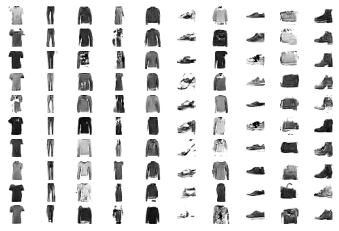

In [16]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)